In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import glob2
import cv2
import PIL.Image
from matplotlib import pylab as P
from matplotlib import pylab as plt
import saliency.core as saliency


# From our repository.
from matplotlib import gridspec
%matplotlib inline

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessImage(im):
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im

def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [39]:
N_IMAGES = 3
INPUT_DIR = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/"
OUT = "./EXAMPLES/CUSTOMCNN-XRAY-TRUE.png"
files = glob2.glob(INPUT_DIR+"*/*.png")

In [40]:
metodos = ['Original',
 'Gradient',
 'SmoothGrad',
 'Input-Grad',
 'IntegratedGradients',
 'GuidedIG',
 'BlurIG',
 'GradCam',
 'RISE',
 'XRAI',
 'LIME']

In [43]:
files_to_show = [files[i].split("/")[-1] for i in [0, 2]] #Primeiras de cada label
labels = [file.split("-")[0] for file in files_to_show] 

In [44]:
files_to_show

['NORMAL-528189-0001.png', 'VIRUS-7979-0001.png']

In [45]:
masks = []
for file in files_to_show:    
    metodo_dict = {}
    for metodo in metodos:
        path_metodo = INPUT_DIR+metodo+"/"+file
        metodo_dict[metodo] = LoadImage(path_metodo)
    masks.append(metodo_dict)

In [46]:
def vis_norms(dicts):
    abs_norm = {}
    no_abs_norm = {}
    norm_0_1 = {}
    for key in dicts:
        mask = dicts[key]
        if(key == "Original"):
            mask_abs_norm = mask
            mask_no_abs_norm = mask
            mask_0_1_norm = mask
        else:
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)

        abs_norm[key] = mask_abs_norm
        no_abs_norm[key] = mask_no_abs_norm
        norm_0_1[key] = mask_0_1_norm
    return abs_norm, no_abs_norm, norm_0_1

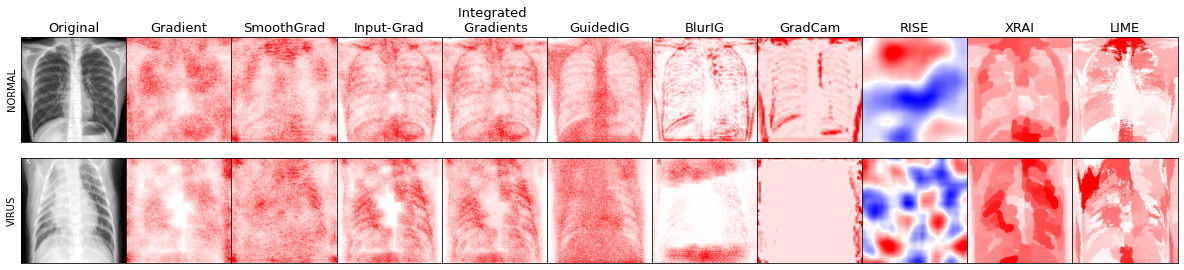

In [47]:
def vis(list_masks, labels, type_vis, OUT, cmap='bwr'):
    nrows = len(list_masks)
    ncols = len(list_masks[0])
    fig = plt.figure(figsize=(ncols*2,nrows*3))
    gs = gridspec.GridSpec(nrows+1, ncols,
                       wspace=0.0, hspace=0.0, left=0.12, bottom=0.08, right=0.85, top=0.92)
    
    row = 0
    for masks in list_masks:
        abs_norm, no_abs_norm, norm_0_1 = vis_norms(masks)
        output_masks_dict = [abs_norm, no_abs_norm, norm_0_1][type_vis]
        mask_order = list(output_masks_dict.keys())
        count = 1
        pad_size=5

        ax = plt.subplot(gs[row, 0])
        ax.imshow(output_masks_dict["Original"])
        ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_ylabel(labels[row])
        if(row == 0):
            ax.set_title("Original", fontsize=13, pad=pad_size)

        for i in range(1, ncols, 1):
            ax = plt.subplot(gs[row, i])
            ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False), 3,7
            if(mask_order[count] == "RISE"):
                mask = abs_norm[mask_order[count]]
                im = ax.imshow(mask, cmap = 'bwr')
                #ax_bar = plt.subplot(gs[3, i])
                #ax_bar.tick_params(left = False, right = False , labelleft = False ,
                #labelbottom = False, bottom = False)
                #fig.colorbar(im, location = "top", pad=0.8, ax=ax_bar)
            elif(mask_order[count] == "LIME"):
                mask = abs_norm[mask_order[count]]
                im = ax.imshow(mask, cmap = 'bwr', vmin  = -mask.max(), vmax = mask.max())
                
                #ax_bar = plt.subplot(gs[3, i])
                #ax_bar.tick_params(left = False, right = False , labelleft = False ,
                #labelbottom = False, bottom = False)
                #fig.colorbar(im, location = "bottom", pad=0.8, ax=ax_bar)
                
            elif(mask_order[count] == "XRAI"):
                mask = abs_norm[mask_order[count]]
                im = ax.imshow(mask, cmap = 'bwr', vmin  = -mask.max(), vmax = mask.max())

            else:
                ax.imshow(abs_norm[mask_order[count]], vmin=-1.0, vmax=1.0, cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if(row == 0):
                title = mask_order[count]
                if(mask_order[count] == "IntegratedGradients"):
                    title = "Integrated \n Gradients"
                ax.set_title(title, fontsize=13, pad=pad_size)
            # increment count
            count +=1
        row += 1
    plt.savefig(OUT,transparent= False, bbox_inches= 'tight', dpi= 400)
    plt.show()

    
    return plt
    
plt = vis(masks, labels, 0, OUT)